# Intro to this package, Part 1
---

Here we introduce the functionalities of our package and the dynamical models it uses.

## 0. Setup
---
Uncomment the following line to install `rl4greencrab`. 
After installation you need to restart the jupyter kernel in order to use the package and run this notebook.

In [1]:
# %pip install -e ..

In [2]:
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, geom_violin, facet_grid, labs, theme, facet_wrap

## 1. Green crab population dynamics environment
---

We model the dynamics of an invasive crab population at one site (e.g. a bay or estuary) using a size-resolved model with 21 size classes.
This dynamics is encapsulated into an environment class `greenCrabEnv`.
Let's declare the env and initialize it using the `.reset()` function.

In [3]:
from rl4greencrab import greenCrabEnv
from rl4greencrab import simulator, constAction, constActionNatUnits

gce = greenCrabEnv()
gce.reset()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), {})

As the name implies, this resets the state of the env to some initial value. 
Additionally, it returns two outputs: the first is an *observation* (whose meaning we will cover in the next section) and the second is an *information dict*.
This type of information dicts can be useful for debugging and generally logging detailed information about the env's state.
We will ignore information dicts throughout this tutorial.

## 2. Dynamics
---

The dynamics of the system all occur within the `.step()` function.
This function evolves the state of the system one time-step, which in our model corresponds to one year.
The `.step()` function requires one argument, an *action*, which is the number of crab traps set in that bay throughout the year.
Actions can currently take values between 0 and 2000:

In [4]:
gce.action_space

Box(0.0, 2000.0, (1,), float32)

The attribue `gce.action_space` is of the type `gymnasium.spaces.Box`, a standard class used for action spaces in the RL world.

Let's try and calling the step function to see what comes out.

In [5]:
gce.step(0)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 -0.0001252673808751487,
 False,
 False,
 {})

The output here is:

`observation`, `reward`, `terminated`, `truncated`, `info`

We won't go into the last three outputs here as they are irrelevant for this notebook.
Here, I want to focus on the `observation` and the `reward` outputs.

`observation` is a sequence of nine numbers, in this case they are all zero.
These numbers correspond to crab catch counts for each of nine months in the year (we do not produce count data in the gestation period of the year, which is three months long).
The reason they are all zero is that we laid zero traps this time-step.
For example, let's look at the observations resulting from different numbers of traps:

In [6]:
list(gce.step(10)[0]), list(gce.step(100)[0]), list(gce.step(1000)[0])

([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 4.0, 0.0, 4.0],
 [28.0, 17.0, 38.0, 31.0, 45.0, 66.0, 46.0, 69.0, 80.0],
 [523.0, 290.0, 231.0, 180.0, 204.0, 226.0, 232.0, 261.0, 273.0])

Notice that for high numbers of traps---in the case above in the case where 1000 traps are laid---, we can see a decrease in catch counts as the year progresses.
This is due to the diminishing population as a consequence of the traps laid.

### Rewards

The `reward` output is computed by balancing out two simultaneous goals of the agent: 1. to minimize the environmental damage produced by the invasive green crab population, and, 2. to minimize the cost of laying traps and removing trapped crabs.
We will examine the reward function in more detail later in this notebook.

### Structure of the decision problem

This is the structure of the decision problem defined by `greenCrabenv`:
The agent observes green crab catch counts each month for 9 months and then, based on that data, the agent chooses the number of traps to lay next year.
The cycle then repeats, and it repeats for an *episode* of 100 time-steps.
The goal of the agent is to choose a policy that maximizes the average reward it receives over an episode.
Because of how we've set up our reward function, this policy will balance the need to keep the invasive population in check with the cost of doing so.

## 3. Crab size distribution
---

As mentioned, our model describes the size distribution of crabs using 21 size classes. 
At any point in the dynamics, this ''internal'' state of the environment is stored as `gce.state`.
Let's plot how this size distribution evolves over time when subjected to different numbers of traps.

/tmp/ipykernel_4340/3331235125.py:8: RuntimeWarning: invalid value encountered in divide
/opt/venv/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 21 rows containing missing values.


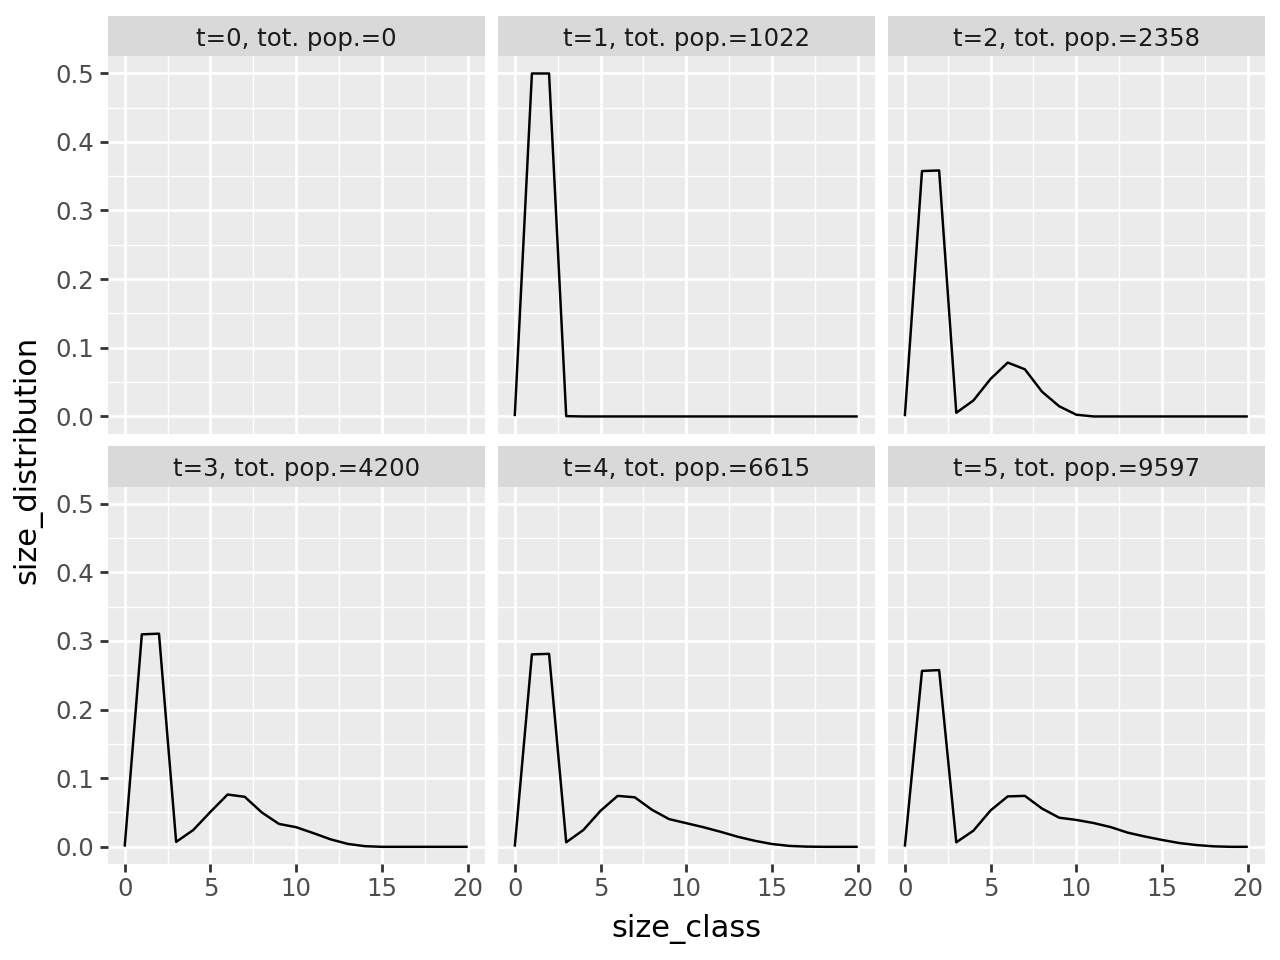

In [7]:
gce.reset()

size_dist = pd.DataFrame()

for t in range(6):
    new_size_dist = pd.DataFrame(
        {
            'size_distribution': gce.state / sum(gce.state),
            'size_class': list(range(21)),
            'label': 21*[f"t={t}, tot. pop.={int(sum(gce.state))}"],
        }
    )
    size_dist = pd.concat(
        [size_dist, new_size_dist],
        ignore_index=True,
    )
    gce.step(0)
(
    ggplot(size_dist, aes(x='size_class',y='size_distribution')) 
    + geom_line() 
    + facet_wrap(facets='label',) 
    # + labs(title=f"N. traps = 0, final pop = {sum(gce.state):.0f}")
    + theme(aspect_ratio=1)
)



Here we see that the relative distribution of sizes converges to a bimodal shape, and that the total crab population increases over time. 
If we were to run this simulation further, we would see the total crab population saturating at around its carrying capacity of 25 000.

### Crab size distribution with traps

Let's try the same code above but laying out a non-zero number of traps.

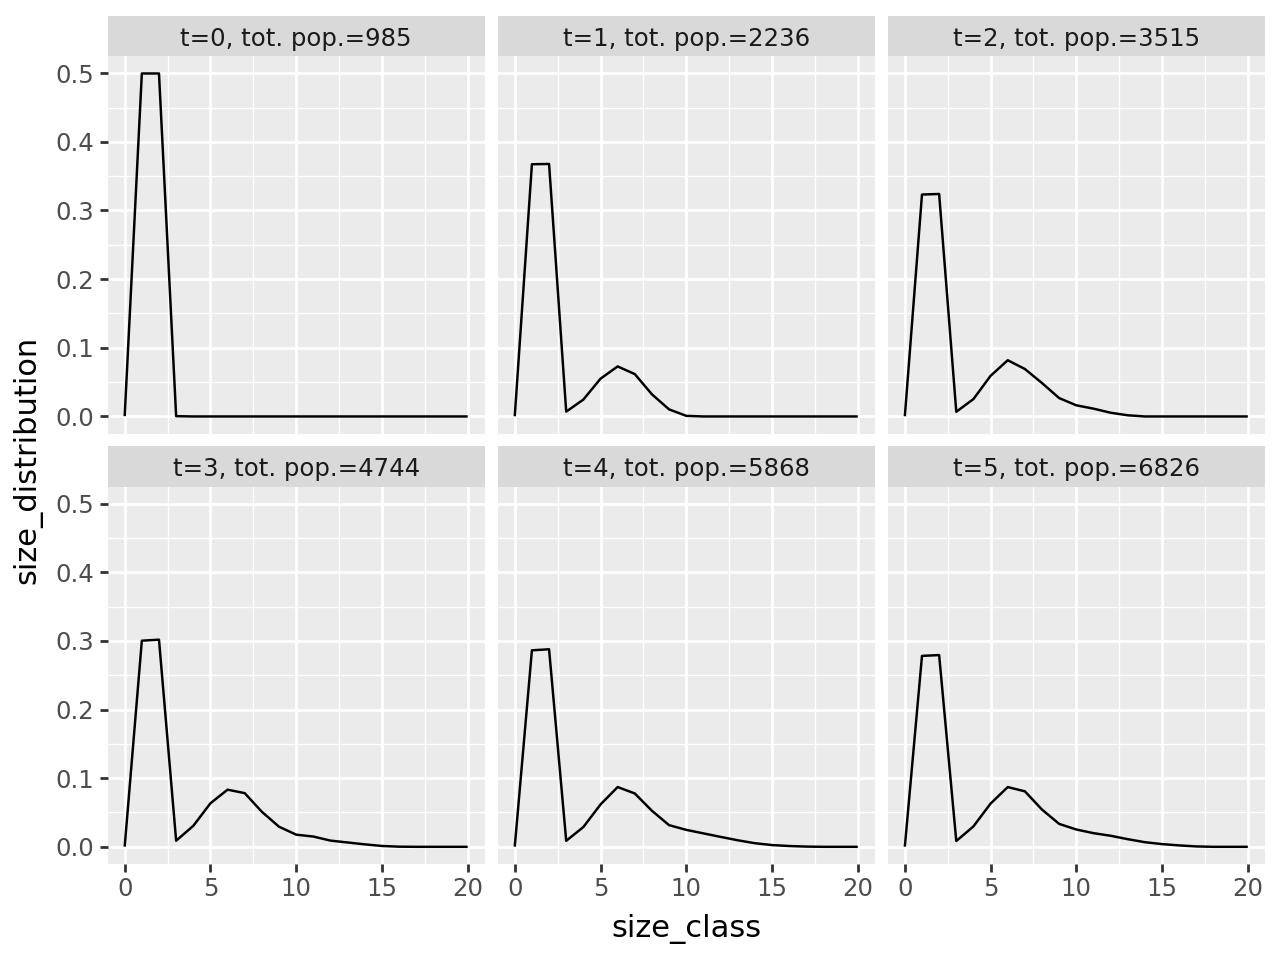

In [8]:
n_traps = 100
gce.reset()
size_dist = pd.DataFrame()

for t in range(6):
    gce.step(n_traps)
    new_size_dist = pd.DataFrame(
        {
            'size_distribution': gce.state / sum(gce.state),
            'size_class': list(range(21)),
            'label': 21*[f"t={t}, tot. pop.={int(sum(gce.state))}"],
        }
    )
    size_dist = pd.concat(
        [size_dist, new_size_dist],
        ignore_index=True,
    )
(
    ggplot(size_dist, aes(x='size_class',y='size_distribution')) 
    + geom_line() 
    + facet_wrap(facets='label',) 
    # + labs(title=f"N. traps = 0, final pop = {sum(gce.state):.0f}")
    + theme(aspect_ratio=1)
)



Here we notice two things:
First, as expected, the population growth is limited by the traps, and seems to saturate around the 4 000 mark.
Second. the *relative* size distribution converges to a a different shape in this case too.

This second point reveals a property of our model: the traps are size selective!
In fact, the traps included in this initial model of `greenCrabEnv`, are good at catching middle-sized crabs, but bad at catching large or small crabs.
In the near future we will include more models in this package that allow for the agent to choose between different trap types.

## 4. Tuning constant action agents

The simplest type of strategy for this management problem would be a non-adaptive one: a fixed number of traps are laid out at the beginning of the episode and they catch crabs for the entire episode.
We now tune this strategy by finding the number of traps that obtains the best reward value.

In [9]:
def evaluateConstAct(x):
    env = greenCrabEnv()
    agent = constActionNatUnits(x[0])
    rewards = simulator(env, agent).simulate()
    out = np.mean(rewards)
    return - out

In [10]:
print("avg episode rewards for some constant action choices:")
- evaluateConstAct([0]), - evaluateConstAct([10]), - evaluateConstAct([100])

avg episode rewards for some constant action choices:


(-24.990284526880874, -24.878529531616216, -8.973712696177108)

### Optimization

We'll try two methods from the `scikit-optimize` package to tune our constant action strategy.

In [12]:
from skopt import gp_minimize, gbrt_minimize 

In [13]:
%%time
res = gp_minimize(evaluateConstAct, [(0.0, 2000.)], n_calls = 120)
res.x

CPU times: user 7min 44s, sys: 44min 53s, total: 52min 37s
Wall time: 1min 7s


[357.5767863558348]

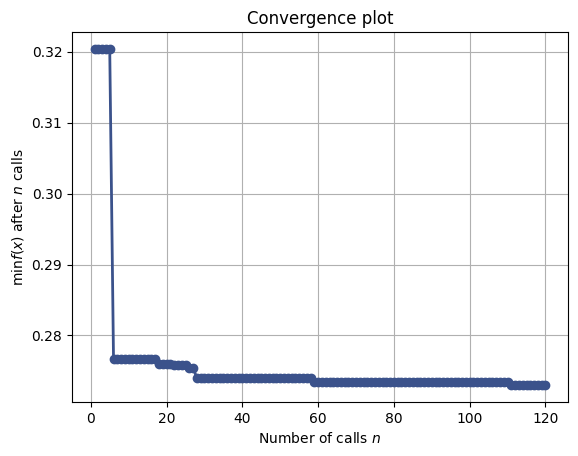

In [14]:
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt
plot_convergence(res)
plt.show()

In [15]:
%%time
res = gbrt_minimize(evaluateConstAct, [(0.0, 2000.)], n_calls = 120)
res.x

CPU times: user 19.2 s, sys: 11.7 ms, total: 19.2 s
Wall time: 19.2 s


[356.2889523075797]

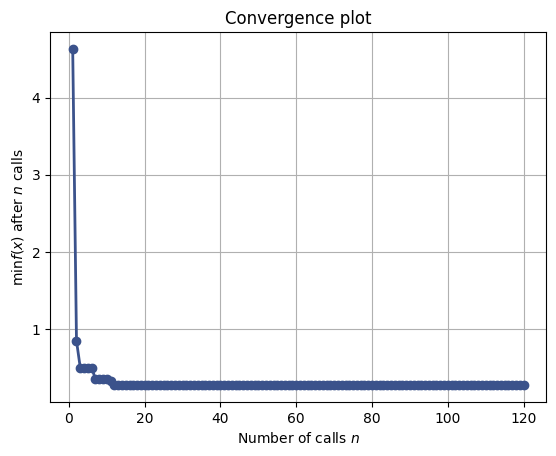

In [16]:
plot_convergence(res)
plt.show()

# validate by looking:

In [17]:
ntrap_choices = [20 * i for i in range(101)]
df = pd.DataFrame(
    {'rew': [evaluateConstAct([ntraps]) for ntraps in ntrap_choices],
     'ntraps': ntrap_choices}
)
df.plot(x='ntraps', logy=True)

<Axes: xlabel='ntraps'>

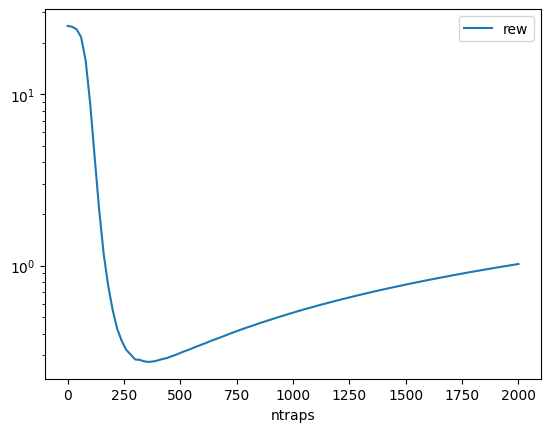

In [18]:
import matplotlib.pyplot as plt
plt.show()

In [29]:
evaluateConstAct([0]), evaluateConstAct([100]), evaluateConstAct([356]), evaluateConstAct([1000])

(25.030327726657944, 9.07276865739476, 0.27581727080079455, 0.5314346767312571)